# import the necessary packages

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import time

import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
# import the necessary packages
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from encoder import *
from pairing import *

<ipython-input-1-5c9830f43a76>:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Idea From 

[Siamese Convolutional Networks for Cognate Identification by Taraka Rama](https://aclanthology.org/C16-1097.pdf)

# Basic 

# Global Variables

In [2]:
import os
# specify the shape of the inputs for our network
IMG_SHAPE = (25, 25, 1)
# specify the batch size and number of epochs
BATCH_SIZE = 64
EPOCHS = 300
# define the path to the base output directory
BASE_OUTPUT = "output"
# use the base output path to derive the path to the serialized
# model along with training history plot
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

LOG_DIR = f"{int(time.time())}"

In [3]:
class myCallback(Callback):
    def on_epoch_end(self,epoch,logs={}):
        if((logs.get('accuracy') > 0.9) and (logs.get('val_accuracy') > 0.74)):
            print("\n[INFO] Reached target accuracy so canceling training")
            self.model.stop_training = True

# Training Data

In [4]:
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
    
	plt.show()
    

 # load the necessarry data 

In [5]:
df = pd.read_excel("/Users/haroldsmith/Desktop/CognatePredictor/conjoined_hash_table.xlsx")


In [6]:
vals = np.arange(1,20,1)

df_no_label = df.loc[~df["Phonological Cognate"].isin(vals)]
located = df.loc[df["Phonological Cognate"].isin(vals)]

located["Phonological Cognate"] = located["Phonological Cognate"].to_numpy() - 1





<ipython-input-6-e0ab748b9143>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  located["Phonological Cognate"] = located["Phonological Cognate"].to_numpy() - 1


In [7]:

located

,Primary ID,prac_rep,tech_rep,spanish,english,latin,source,Phonological Cognate,Cognates,Proto-Zapotecan,Same Referent,Looser comparison,PZap_gloss,BiblioRef,Cordova_ethnobot
82,67061,NaN,bziàa-bǐch-ngǎs,NaN,NaN,Fabaceae Vigna unguiculata(var.),San Juan Mixtepec Zapotec,10.0,ngǎs,k-assak,NaN,NaN,black,NaN,NaN
99,67078,NaN,bziàa-dùuzh-ngǎs,NaN,NaN,Fabaceae Phaseolus vulgaris(var.),San Juan Mixtepec Zapotec,10.0,ngǎs,k-assak,NaN,NaN,black,NaN,NaN
102,67081,NaN,bziàa-dùuzh-pînt-ngǎs,NaN,NaN,Fabaceae Phaseolus vulgaris(var.),San Juan Mixtepec Zapotec,10.0,ngǎs,k-assak,NaN,NaN,black,NaN,NaN
108,67087,NaN,bziàa-ngǎs,NaN,NaN,Fabaceae Phaseolus vulgaris(var.),San Juan Mixtepec Zapotec,10.0,ngǎs,k-assak,NaN,NaN,black,NaN,NaN
124,67103,NaN,càrpìntêr-ngǎs,NaN,NaN,Melanerpes formicivorus,San Juan Mixtepec Zapotec,10.0,ngǎs,k-assak,NaN,NaN,black,NaN,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53313,321226,queeza,quèeza,picietl yerua que embeleña o emborracha. tabac...,NaN,NaN,Cordova,17.0,quèeza,ke7sa,NaN,NaN,NaN,NaN,Yes
60691,328604,quijxitiche,quijxi-tíche,roçado assi antes que se pegue fuego. [roçar m...,NaN,NaN,Cordova,18.0,quijxi,kixi,NaN,NaN,NaN,NaN,Yes
70638,338551,peea,peea,xetas o hongos,NaN,NaN,Cordova,15.0,peea,kw+ e7ya,NaN,NaN,NaN,NaN,Yes
70639,338552,peya,peya,xetas o hongos,NaN,NaN,Cordova,15.0,peya,kw+ e7ya,NaN,NaN,NaN,NaN,Yes


# EDA

In [8]:
df["tech_rep"].describe()

count     70085
unique    62605
top         lào
freq         41
Name: tech_rep, dtype: object

In [9]:
df["source"].value_counts(0)

Cordova                      66978
San Juan Mixtepec Zapotec     1804
Diidxazá                      1062
Zenzontepec Chatino           1020
Name: source, dtype: int64

In [10]:
df["length_tech_rep"] = df["tech_rep"].str.len()

df["length_tech_rep"].describe()

count    70085.000000
mean        15.889991
std          8.284613
min          1.000000
25%         10.000000
50%         14.000000
75%         20.000000
max        156.000000
Name: length_tech_rep, dtype: float64

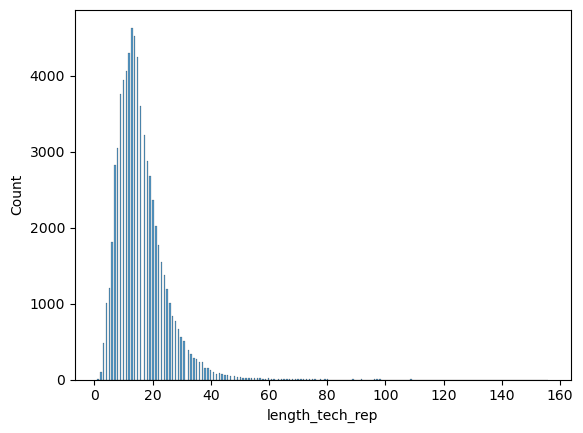

In [11]:
import seaborn as sns
sns.histplot(df["length_tech_rep"])
plt.show()

# ENCODING

In [12]:
images = located["tech_rep"].to_numpy()
labels = located["Phonological Cognate"].to_numpy().astype(np.int64)
words_to_translate = df_no_label["tech_rep"]
training_images = encoding(images)
testing_images = encoding(words_to_translate)




**********************
[INFO] ENCODING DATA
**********************


**********************
[INFO] ENCODING DATA
**********************



# Example of how they are Encoded

In [13]:
pairTrain, labelTrain = make_pairs(training_images,labels)
word_pairs, cognate = make_pairs(images, labels)

plt.figure()
plt.imshow(pairTrain[1,1])

print("Associated Word = ",word_pairs[2,1] )
plt.show()

IndexError: index 425 is out of bounds for axis 0 with size 425

In [ ]:
def build_siamese_model(hp):
    # specify the inputs for the feature extractor network
    inputs = Input(IMG_SHAPE)
    # define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(hp.Int(
        'units 1',
        min_value=32,
        max_value=512,
        step=16,
        default=128), (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))(x)
    # second set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(hp.Int(
        'units 2',
        min_value=32,
        max_value=512,
        step=32,
        default=128), (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(hp.Float(
                'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))(x)
    # prepare the final outputs
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(hp.Float(
                'Embeding Dim',
                min_value=12,
                max_value=60,
                default=48,
                step=12,
            ))(pooledOutput)
    # build the model
    featureExtractor = Model(inputs, outputs)
    
    imgA = Input(shape = IMG_SHAPE)
    imgB = Input(shape = IMG_SHAPE)
    
    #print(featureExtractor)
    
    featsA = featureExtractor(imgA)
    featsB = featureExtractor(imgB)
    
    distance = Lambda(euclidean_distance)([featsA, featsB])
    outputs = Dense(1, activation= "sigmoid")(distance)
    model1 = Model(inputs=[imgA, imgB], outputs=outputs)
    #print(model1.summary())
    opt = tf.keras.optimizers.Adam(learning_rate=hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                ))
    print("[INFO] compiling model...")
    model1.compile(loss="binary_crossentropy", optimizer= opt,
	metrics=["accuracy"])
    return model1
    # return the model to the calling function
   

In [ ]:
callbacks = myCallback()

In [ ]:

#hyperparameter tuning
tuner = RandomSearch(build_siamese_model,
                    objective = 'val_accuracy',
                    max_trials = 10,
                    executions_per_trial = 1,
                    directory = LOG_DIR)

tuner.search(x = [pairTrain[:, 0], pairTrain[:, 1]],
             y = labelTrain[:],
             epochs = 50,
             batch_size = 64,
             validation_split=(0.3) 
             
            )
            



INFO:tensorflow:Reloading Oracle from existing project 1638504505/untitled_project/oracle.json
[INFO] compiling model...
INFO:tensorflow:Reloading Tuner from 1638504505/untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


# Best Model

In [ ]:
print(tuner.get_best_hyperparameters()[0].values)
#print(tuner.results_summary())
#print(tuner.get_best_models()[0].summary())
tuned_param = tuner.get_best_hyperparameters()[0].values

tuned_param['units 1']

{'units 1': 128, 'dropout_1': 0.05, 'units 2': 352, 'dropout_2': 0.05, 'Embeding Dim': 48.0, 'learning_rate': 0.007644732340148274}


128

# Optimized Model

In [ ]:
def build_siamese_model():
    # specify the inputs for the feature extractor network
    inputs = Input(IMG_SHAPE)
    # define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(tuned_param['units 1'], (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(tuned_param['dropout_1'])(x)
    # second set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(tuned_param['units 2'], (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(tuned_param['dropout_2'])(x)
    # prepare the final outputs
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(tuned_param['Embeding Dim'])(pooledOutput)
    # build the model
    featureExtractor = Model(inputs, outputs)
    
    imgA = Input(shape = IMG_SHAPE)
    imgB = Input(shape = IMG_SHAPE)
    
    #print(featureExtractor)
    
    featsA = featureExtractor(imgA)
    featsB = featureExtractor(imgB)
    
    distance = Lambda(euclidean_distance)([featsA, featsB])
    outputs = Dense(1, activation= "sigmoid")(distance)
    model1 = Model(inputs=[imgA, imgB], outputs=outputs)
    #print(model1.summary())
    opt = tf.keras.optimizers.Adam(learning_rate=tuned_param['learning_rate'])
    print("[INFO] compiling model...")
    model1.compile(loss="binary_crossentropy", optimizer= opt,
	metrics=["accuracy"])
    return model1

In [ ]:
callbacks = myCallback()
model = build_siamese_model()
model.summary()

[INFO] compiling model...
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
model_2 (Functional)            (None, 48)           198160      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           m

# Prediction & Fitting


In [ ]:

history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_split=(0.2),
	batch_size= BATCH_SIZE, 
	epochs= 100,
    callbacks = callbacks)
    # serialize the model to disk<br>
print("[INFO] saving siamese model...")
model.save(MODEL_PATH)
# plot the training history<br>



Epoch 1/100
11/11 [==============================] - 4s 319ms/step - loss: 0.6929 - accuracy: 0.5015 - val_loss: 0.6928 - val_accuracy: 0.5118
Epoch 2/100
11/11 [==============================] - 4s 314ms/step - loss: 0.6892 - accuracy: 0.5456 - val_loss: 0.6984 - val_accuracy: 0.5176
Epoch 3/100
11/11 [==============================] - 3s 233ms/step - loss: 0.6863 - accuracy: 0.5618 - val_loss: 0.6882 - val_accuracy: 0.5706
Epoch 4/100
11/11 [==============================] - 3s 237ms/step - loss: 0.6800 - accuracy: 0.6221 - val_loss: 0.6821 - val_accuracy: 0.5706
Epoch 5/100
11/11 [==============================] - 3s 229ms/step - loss: 0.6744 - accuracy: 0.5794 - val_loss: 0.6610 - val_accuracy: 0.5647
Epoch 6/100
11/11 [==============================] - 3s 234ms/step - loss: 0.6579 - accuracy: 0.6750 - val_loss: 0.6699 - val_accuracy: 0.5824
Epoch 7/100
11/11 [==============================] - 3s 235ms/step - loss: 0.6424 - accuracy: 0.6265 - val_loss: 0.6477 - val_accuracy: 0.6000

[INFO] plotting training history...


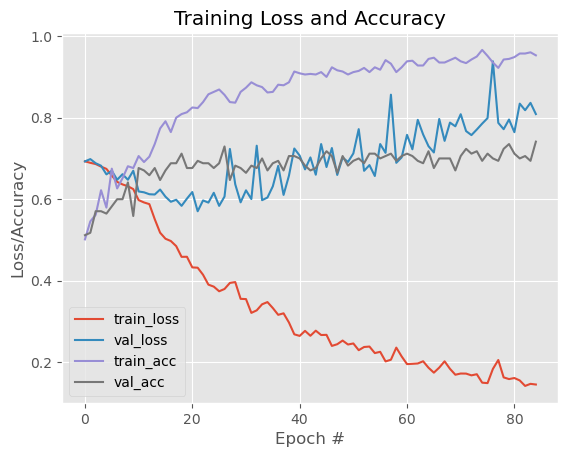

In [ ]:
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

In [ ]:



test_labels = associated_labels[0:1]
test_pred_images = encoding(test_prediction_words)

plt.figure()

plt.imshow(test_pred_images[0])

model = load_model(MODEL_PATH)

test_prediction_words = words_to_translate
test_pred_images = encoding(test_prediction_words)
test_prediction_words_endcode = np.expand_dims(encoding(test_prediction_words),axis = -1)
predict_train = np.expand_dims(test,axis = -1)



In [ ]:
len(test_prediction_words_endcode)

70866

In [ ]:
pairs = []
for i in range(len(test_prediction_words_endcode)):
    pairs.append([test_prediction_words_endcode[0],test_prediction_words_endcode[i]])
    

pairs = np.array(pairs)


In [ ]:
pairs.shape

(70866, 2, 25, 25, 1)

In [ ]:
prediction = model.predict([pairs[:, 0], pairs[:, 1]])


In [ ]:
cognate_index = []
for i in range(len(prediction)):
    if(prediction[i] > 0.82):
        cognate_index.append(i)

In [ ]:
words_to_translate[np.argmax(prediction)]

'cica-lo+huáa-le çàca nócha'

In [ ]:
min(prediction)

array([0.00251958], dtype=float32)

In [ ]:
words_to_translate[0]

'hue+róxo quijxi'

In [ ]:
words_to_translate[np.argmax(prediction)]

'hue+róxo quijxi'

In [ ]:
test1 = encoding(words_to_translate[0])
test2 = encoding(words_to_translate[np.argmax(prediction)])

np.expand_dims(test1,axis = -1).shape

(15, 25, 25, 1)

# Work with LingPy

In [ ]:
from lingpy import *

In [ ]:
df_source_and_words = df[["tech_rep","source"]].dropna()

In [ ]:
def meaningful(words:list):
    print("**********************")
    print("RETURNING MEANINGFUL CHARACTERS")
    print("**********************")
    print()
    word_translated = []
    for word in words:
        if(type(word) != float):
            chars = list(word)
            # print(chars)
            k = 0
            phenomes_endcode = []
            for char in chars:
                if(char in symbols):
                #print(encoding_dict[char])
                    phenomes_endcode.append(char)
            word_translated.append("".join(phenomes_endcode))
    return word_translated

In [ ]:


df_source_and_words["tech_rep"] = meaningful(df_source_and_words["tech_rep"].tolist())


**********************
RETURNING MEANINGFUL CHARACTERS
**********************



In [ ]:
df_source_and_words.groupby(["source"]).count()
# need to make a datafram out of these but they are wildly the wronf shapes
# would it be bad practice to just continuely take 1020 from each of them until all possible

,tech_rep
source,
Cordova,66202
Diidxazá,1059
San Juan Mixtepec Zapotec,1804
Zenzontepec Chatino,1020


In [ ]:
langs = pd.unique(df_source_and_words["source"].dropna()).tolist()
langs

['San Juan Mixtepec Zapotec', 'Zenzontepec Chatino', 'Diidxazá', 'Cordova']

In [ ]:
dic = {'San Juan Mixtepec Zapotec':[],'Zenzontepec Chatino':[],'Diidxazá':[],'Cordova':[]}

In [ ]:

max_len = 0
max_index = 0
for lang in langs:
    for index, row in df_source_and_words.iterrows():
        if len(row["tech_rep"]) > max_len:
            max_len = len(row["tech_rep"])
            max_index = index
        if row["source"] == lang:
            dic[lang].append(row["tech_rep"])

print("longest word",df_source_and_words.loc[df_source_and_words.index == max_index])

longest word                                                 tech_rep   source
19237  tòagrpreteritocotòagrfuturohuetòuaquitòuacorti...  Cordova


In [ ]:
print("legnth of longest word",max_len)

legnth of longest word 93


In [ ]:
pd.DataFrame.from_dict(data = dic)

ValueError: arrays must all be same length